In [2]:
!unzip train.zip
!unzip test.zip

Archive:  train.zip
  inflating: train.csv               
  inflating: user_features.csv       
Archive:  test.zip
  inflating: test.csv                


In [25]:
import pandas as pd
import numpy as np

In [26]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [27]:
user_features=pd.read_csv('user_features.csv')

In [28]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
user_features=reduce_mem_usage(user_features)


Memory usage after optimization is: 606.50 MB
Decreased by 62.5%
Memory usage after optimization is: 134.78 MB
Decreased by 50.0%
Memory usage after optimization is: 133.98 MB
Decreased by 84.8%


In [29]:
train_1=pd.merge(train, user_features, how='left', left_on='node1_id', right_on='node_id')

In [30]:
train_1=train_1.drop(['node_id'],axis=1)

In [31]:
train_2=pd.merge(train_1, user_features, how='left', left_on='node2_id', right_on='node_id')

In [32]:
train_2=train_2.drop(['node_id','node1_id','node2_id'],axis=1)

In [10]:
#train_2=train_2.drop_duplicates()

In [34]:
for i in range(1,14,1):
    train_2['f_avg'+str(i)]=np.round((train_2['f'+str(i)+'_x']+train_2['f'+str(i)+'_y'])/2)

In [37]:
for col in train_2.columns:
    train_2[col]=train_2[col].astype('category')

In [38]:
train_2.head()

,is_chat,f1_x,f2_x,f3_x,f4_x,f5_x,f6_x,f7_x,f8_x,f9_x,...,f_avg4,f_avg5,f_avg6,f_avg7,f_avg8,f_avg9,f_avg10,f_avg11,f_avg12,f_avg13
0,0,22,0,0,24,0,0,24,0,0,...,20.0,6.0,2.0,22.0,6.0,2.0,21.0,5.0,2.0,12.0
1,0,0,0,0,0,0,0,0,0,0,...,8.0,6.0,3.0,10.0,8.0,4.0,12.0,10.0,3.0,11.0
2,0,9,2,0,14,7,1,14,7,1,...,8.0,4.0,0.0,8.0,4.0,0.0,7.0,4.0,0.0,12.0
3,0,11,11,10,11,10,9,10,9,8,...,6.0,6.0,5.0,6.0,5.0,4.0,4.0,4.0,4.0,11.0
4,0,31,31,31,31,31,31,31,31,31,...,19.0,16.0,16.0,20.0,16.0,16.0,24.0,16.0,15.0,7.0


In [40]:
y_train=train_2['is_chat']

In [41]:
train_2=train_2.drop(['is_chat'],axis=1)

In [42]:
train_2.shape

(70661802, 39)

In [43]:
y_train.shape

(70661802,)

In [44]:
params_tuned = {
#     'bagging_freq': 5,
#    'bagging_fraction': 0.9,
#    'boost_from_average':'false',
    'boost': 'gbdt',
#     'feature_fraction': 0.05,
    'learning_rate': 0.15,
    'max_depth': -1,  
    'metric':'auc',
#    'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
#     'num_leaves': 13,
    'num_threads': -1,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_leaves': 100,
    "device" : "gpu",
    "gpu_platform_id" : 0,
    "gpu_device_id" : 0
    
}

In [45]:
import time
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_valid, Y_train, Y_valid =train_test_split(train_2,y_train,test_size=0.2,stratify=y_train)

In [47]:
del train_1,train

In [48]:
train_data = lgb.Dataset(X_train, label=Y_train,free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=Y_valid,free_raw_data=False)

In [49]:
import gc
gc.collect()

1042

In [50]:
#from sklearn.externals import joblib

In [51]:
#gbm_pickle = joblib.load('lgb.pkl')

In [52]:
#del X_train, Y_train

In [53]:
# callback
def save_model():
    def callback(env):
        model=env.model
        if env.iteration%100==0:
            model.save_model('model_'+str(env.iteration)+'.txt')
    callback.before_iteration = False
    callback.order = 0
    return callback

In [ ]:
lgb_model = lgb.train(params_tuned,train_data,num_boost_round=10000,
                valid_sets = [valid_data],verbose_eval=100,early_stopping_rounds = 300,callbacks=[save_model()])

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[100]	valid_0's auc: 0.850995
[200]	valid_0's auc: 0.852923
[300]	valid_0's auc: 0.853856
[400]	valid_0's auc: 0.854556
[500]	valid_0's auc: 0.855117
[600]	valid_0's auc: 0.855484
[700]	valid_0's auc: 0.855824
[800]	valid_0's auc: 0.856053
[900]	valid_0's auc: 0.856193
[1000]	valid_0's auc: 0.85634
[1100]	valid_0's auc: 0.856434


In [23]:
# from sklearn.externals import joblib
# joblib.dump(lgb_model, 'lgb_10000.pkl')

['lgb_10000.pkl']

In [24]:
# gbm_pickle=joblib.load('lgb_10000.pkl')

In [25]:
# gbm_pickle.best_iteration

2846

In [55]:
ids=test.id

In [56]:
test_1=pd.merge(test, user_features, how='left', left_on='node1_id', right_on='node_id')

In [57]:
test_1=test_1.drop(['node_id'],axis=1)

In [58]:
test_2=pd.merge(test_1, user_features, how='left', left_on='node2_id', right_on='node_id')

In [59]:
test_2=test_2.drop(['node1_id','node2_id'],axis=1)

In [60]:
test_2.shape

(11776968, 28)

In [61]:
test_2=test_2.drop(['id','node_id'],axis=1)

In [62]:
del test,test_1

In [92]:
for col in test_2.columns:
    test_2[col]=test_2[col].astype(np.int8)
for i in range(1,14,1):
    test_2['f_avg'+str(i)]=np.round((test_2['f'+str(i)+'_x']+test_2['f'+str(i)+'_y'])/2)
for col in test_2.columns:
    test_2[col]=test_2[col].astype('category')

In [93]:
test_2.head()

,f1_x,f2_x,f3_x,f4_x,f5_x,f6_x,f7_x,f8_x,f9_x,f10_x,...,f_avg4,f_avg5,f_avg6,f_avg7,f_avg8,f_avg9,f_avg10,f_avg11,f_avg12,f_avg13
0,31,6,1,31,6,1,31,8,1,31,...,31.0,15.0,2.0,31.0,16.0,2.0,31.0,18.0,2.0,15.0
1,0,0,0,0,0,0,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,7.0
2,1,1,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
3,14,5,1,12,4,1,6,3,1,0,...,6.0,2.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,15.0
4,31,31,31,31,31,31,31,31,30,31,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,7.0


In [63]:
lgb_load=lgb.Booster(model_file='model_2100.txt')

In [67]:
lgb_load.current_iteration()

2101

In [82]:
valid_preds=lgb_load.predict(X_valid, num_iteration=1851)

In [83]:
len(valid_preds)

14132361

In [84]:
roc_auc_score(Y_valid,valid_preds)

0.8567185278877307

In [94]:
test_preds=lgb_load.predict(test_2, num_iteration=1851)

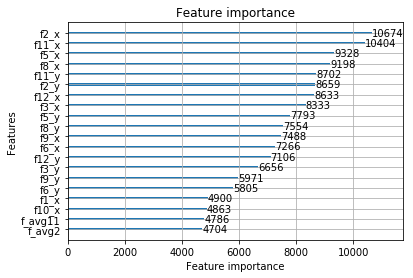

In [95]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_load, max_num_features=20)
plt.show()

In [96]:
sub=pd.DataFrame()
sub['id']=ids
sub['is_chat']=test_preds
sub.to_csv('full_lgb_preds_avg.csv',index=False)
!zip full_lgb_preds_avg.zip full_lgb_preds_avg.csv

updating: full_lgb_preds_avg.csv (deflated 60%)


In [89]:
gc.collect()

171

In [90]:
# gbm = lgb.train(params_tuned,
#                 train_data,
#                 num_boost_round=10,
#                 init_model='model.txt',
#                 valid_sets=[valid_data],
#                 verbose_eval=1,early_stopping_rounds = 300)

In [99]:
train=reduce_mem_usage(pd.read_csv('train.csv'))

Memory usage after optimization is: 606.50 MB
Decreased by 62.5%


In [101]:
train_node_id=set(list(train.node1_id))

In [102]:
train_node2_id=set(list(train.node2_id))

In [103]:
train_node_id.update(train_node2_id)

In [105]:
test=reduce_mem_usage(pd.read_csv('test.csv'))

Memory usage after optimization is: 134.78 MB
Decreased by 50.0%


In [123]:
test_node_id=set(list(test.node1_id))

In [124]:
test_node2_id=set(list(test.node2_id))

In [128]:
test_node_id.update(test_node2_id)

In [113]:
train_node1=train.groupby('node1_id').agg({'is_chat':['sum','mean']}).reset_index()

In [120]:
train_node1.columns=['node1_id','is_chat_node1_sum','is_chat_node1_mean']

In [116]:
train_node2=train.groupby('node2_id').agg({'is_chat':['sum','mean']}).reset_index()

In [118]:
train_node2.columns=['node2_id','is_chat_node2_sum','is_chat_node2_mean']

In [131]:
train_node1['count_chat']=np.round(train_node1['is_chat_node1_sum']/train_node1['is_chat_node1_mean'])

In [132]:
train_node2['count_chat']=np.round(train_node2['is_chat_node2_sum']/train_node2['is_chat_node2_mean'])

In [135]:
train_node1=train_node1.fillna(0)
train_node2=train_node2.fillna(0)

In [130]:
train_fe=pd.DataFrame()
train_fe['node_id']=list(train_node_id)

In [137]:
train_fe=train_fe.merge(train_node1,how='left',left_on='node_id',right_on='node1_id')

In [139]:
del train_fe['node1_id']

In [140]:
train_fe=train_fe.merge(train_node2,how='left',left_on='node_id',right_on='node2_id')

In [141]:
del train_fe['node2_id']

In [142]:
train_fe.head()

,node_id,is_chat_node1_sum,is_chat_node1_mean,count_chat_x,is_chat_node2_sum,is_chat_node2_mean,count_chat_y
0,2,NaN,NaN,NaN,0.0,0.000000,0.0
1,3,0.0,0.0,0.0,2.0,0.051282,39.0
2,4,NaN,NaN,NaN,0.0,0.000000,0.0
3,5,0.0,0.0,0.0,0.0,0.000000,0.0
4,6,0.0,0.0,0.0,1.0,0.033333,30.0


In [143]:
train_fe=train_fe.fillna(0)

In [144]:
train_fe['full_chat_sum']=train_fe['is_chat_node1_sum']+train_fe['is_chat_node2_sum']
train_fe['full_chat_count']=train_fe['count_chat_x']+train_fe['count_chat_y']

In [148]:
train_fe.head()

,node_id,is_chat_node1_sum,is_chat_node1_mean,count_chat_x,is_chat_node2_sum,is_chat_node2_mean,count_chat_y,full_chat_sum,full_chat_count,full_chat_mean
0,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,3,0.0,0.0,0.0,2.0,0.051282,39.0,2.0,39.0,0.051282
2,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,6,0.0,0.0,0.0,1.0,0.033333,30.0,1.0,30.0,0.033333


In [147]:
train_fe['full_chat_mean']=train_fe['full_chat_sum']/train_fe['full_chat_count']
train_fe['full_chat_mean']=train_fe['full_chat_mean'].fillna(0)

In [149]:
train_only_chat=train.loc[train['is_chat']==1]

In [150]:
train_only_chat.shape

(2251784, 3)

In [129]:
# common connections

In [151]:
train_only_chat.node1_id.nunique()

1162935

In [152]:
!pip3 install networkx

    100% |████████████████████████████████| 1.7MB 1.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx
You are using pip version 8.1.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [153]:
import networkx as nx


In [154]:
G = nx.Graph()


In [159]:
train_only_chat=train_only_chat.reset_index(drop=True)

In [162]:
FG = nx.from_pandas_edgelist(train_only_chat, source='node1_id', target='node2_id', edge_attr=True,)

In [171]:
[val for val in FG.neighbors(train_only_chat['node1_id'][0])]

[8119897, 2663250, 475131, 7791327]

In [179]:
common_neighbors=[sum(1 for x in nx.common_neighbors(FG, train_only_chat['node1_id'][ind], train_only_chat['node2_id'][ind])) for ind in range(len(train_only_chat))]

In [180]:
len(common_neighbors)-common_neighbors.count(0)

358661

In [181]:
train_only_chat['common_neighbors']=common_neighbors

In [186]:
train_fe_req=train_fe[['node_id','full_chat_mean','full_chat_sum','full_chat_count']].reset_index()

In [187]:
train_fe_req.head()

,index,node_id,full_chat_mean,full_chat_sum,full_chat_count
0,0,2,0.000000,0.0,0.0
1,1,3,0.051282,2.0,39.0
2,2,4,0.000000,0.0,0.0
3,3,5,0.000000,0.0,0.0
4,4,6,0.033333,1.0,30.0


In [188]:
del train_fe_req['index']

In [189]:
train_fe_req.to_csv('train_fe_vals.csv',index=False)

In [190]:
train_fe_req=pd.read_csv('train_fe_vals.csv',nrows=5)
train_fe_req.head()

,node_id,full_chat_mean,full_chat_sum,full_chat_count
0,2,0.000000,0.0,0.0
1,3,0.051282,2.0,39.0
2,4,0.000000,0.0,0.0
3,5,0.000000,0.0,0.0
4,6,0.033333,1.0,30.0


In [191]:
train_only_chat.to_csv('train_only_chat.csv',index=False)